In [77]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
class Thyroid_Dataset(Dataset):
    def __init__(self, csv_file, transform=None, return_from_dataset = False, crop_DDTI = False, histo_match = False):
        self.csv_file = csv_file
        self.data_path = "../data"
        self.df = pd.read_csv(f"{self.data_path}/{self.csv_file}")
        self.transform = transform
        self.cache = {}
        self.return_from_dataset = return_from_dataset
        self.crop_DDTI = crop_DDTI
        self.histo_match = histo_match
        image_path = self.data_path+f"/tn3k/trainval-image/0001.jpg"
        self.histo_match_image = Image.open(image_path).convert("L")
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        ID = self.df["ID"][idx]
        dataset = self.df["dataset"][idx]
        
        
        if f"{dataset}_{ID}" in self.cache:
            image, mask, seg_type, from_dataset = self.cache[f"{dataset}_{ID}"]
        else:
            # seg_type : 1(nodule), 2(gland)
            if dataset == "DDTI":
                image_path = self.data_path+f"/DDTI dataset/DDTI/1_or_data/image/{ID}.PNG"
                mask_path = self.data_path+f"/DDTI dataset/DDTI/1_or_data/mask/{ID}.PNG"
                # image_path = self.data_path+f"/DDTI dataset/DDTI/2_preprocessed_data/stage2/p_image/{ID}.PNG"
                # mask_path = self.data_path+f"/DDTI dataset/DDTI/2_preprocessed_data/stage2/p_mask/{ID}.PNG"
                seg_type = 1
                from_dataset = 1
            elif dataset == "TG3K":
                ID = str(ID).zfill(4)
                image_path = self.data_path+f"/tg3k/thyroid-image/{ID}.jpg"
                mask_path = self.data_path+f"/tg3k/thyroid-mask/{ID}.jpg"
                seg_type = 2
                from_dataset = 2
            elif dataset == "TN3K":
                ID = str(ID).zfill(4)
                image_path = self.data_path+f"/tn3k/trainval-image/{ID}.jpg"
                mask_path = self.data_path+f"/tn3k/trainval-mask/{ID}.jpg"
                seg_type = 1
                from_dataset = 3
    
            image = Image.open(image_path).convert("L")
            mask = Image.open(mask_path).convert("L")
            if dataset == "DDTI" and self.crop_DDTI:
                # print("before crop : ", image.size)
                image, mask = self.crop_ddti_ultrasound_roi(image, mask)
                # print("after crop : ", image.size)
            self.cache[f"{dataset}_{ID}"] = (image, mask, seg_type, from_dataset)

        if dataset == "DDTI" and self.histo_match:
            image = self.histogram_match(image, self.histo_match_image)
            
        image_tensor = self.transform(image)
        mask_tensor = self.transform(mask)
        mask_tensor = (mask_tensor > 0.5).float()

        seg_type = torch.tensor(seg_type)


        if self.return_from_dataset:
            return image_tensor, mask_tensor, seg_type, from_dataset
        else:
            return image_tensor, mask_tensor, seg_type
    def crop_ddti_ultrasound_roi(self, pil_image, pil_mask, crop_ratio=0.8):
    
        # 中心裁切
        w, h = pil_image.size
        crop_w, crop_h = int(w * crop_ratio), int(h * crop_ratio)
        left = (w - crop_w) // 2
        top = (h - crop_h) // 2
        cropped_image = pil_image.crop((left, top, left + crop_w, top + crop_h))
        cropped_mask = pil_mask.crop((left, top, left + crop_w, top + crop_h))
        
        # 對比增強（幫助分辨紋理）
        enhancer = ImageEnhance.Contrast(cropped_image)
        cropped_image = enhancer.enhance(1.5)  # 可微調，1.5–2 之間效果通常最好

    
        return cropped_image, cropped_mask
    def histogram_match(self, source_pil, reference_pil):
        """
        將 source_pil 的 histogram 調整成與 reference_pil 接近
        """
        source = np.array(source_pil.convert("L"))
        reference = np.array(reference_pil.convert("L"))

    
        matched = match_histograms(source, reference, channel_axis=None)
        matched_img = Image.fromarray(np.uint8(matched))
        return matched_img

In [87]:
image_size = 128
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])
# train_dataset = Thyroid_Dataset("train_v2.csv", transform = transform, aug_type = ["hflip"], show_log = True)
# # train_dataset = Thyroid_Dataset("train_v2.csv", transform = transform, aug_type = None, show_log = True)
# train_dataloader = DataLoader(train_dataset, batch_size = 2, shuffle = True)

test_dataset = Thyroid_Dataset("test_v2.csv", transform = transform, return_from_dataset = True, hito_match = True)
test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle = False)
image, mask, seg_type, from_dataset = next(iter(test_dataloader))

In [83]:
from_dataset

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3,
        3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3,
        1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 3])

tensor(1)
tensor(0.1359)


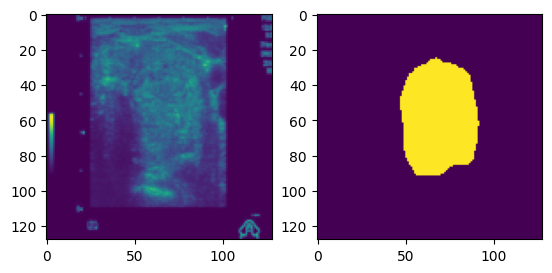

In [86]:
index = 21
print(from_dataset[index])
print(torch.mean(image[index][0]))
plt.subplot(1,2,1)
plt.imshow(image[index][0])
plt.subplot(1,2,2)
plt.imshow(mask[index][0])

tensor(1)
tensor(0.3669)


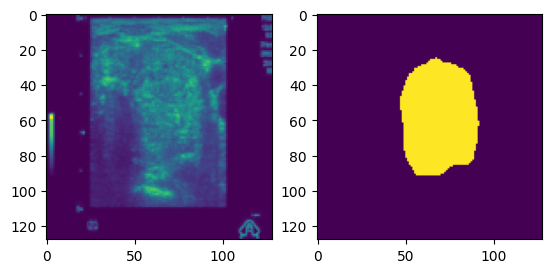

In [88]:
index = 21
print(from_dataset[index])
print(torch.mean(image[index][0]))
plt.subplot(1,2,1)
plt.imshow(image[index][0])
plt.subplot(1,2,2)
plt.imshow(mask[index][0])

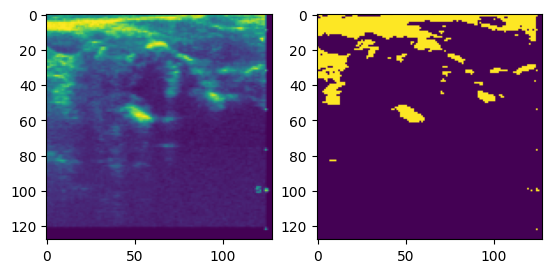

In [41]:
index = 9
plt.subplot(1,2,1)
plt.imshow(image[index][0])
plt.subplot(1,2,2)
plt.imshow(mask[index][0])